In [1]:
!pip install monai

import argparse
import json
import logging
import os
from datetime import datetime
from uuid import uuid4
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
#import monai as M
#import cv2
from tqdm import tqdm
from more_itertools import flatten
from monai.utils import set_determinism
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.nets import UNet, BasicUNet
from monai.networks.utils import one_hot
#from cv2 import findContours
from sklearn.model_selection import LeaveOneOut, KFold


from cmr_haste import utils
from cmr_haste.data import ImageDataset, ImageSegDataset, setup_data
from cmr_haste.losses import DiceLoss, dice_score

try:
    from torch.utils.tensorboard import SummaryWriter
    has_tb = True
except ImportError:
    has_tb = False
    
_logger = logging.getLogger('train')

ModuleNotFoundError: No module named 'cmr_haste'

#### Setup configuration and environment

In [ ]:
dataset_dir = '/home/liam/projects/cmr-haste/data/cmr-haste-data'
out_root = '/home/liam/projects/cmr-haste/output/'
exp_name = '-'.join([datetime.now().strftime("%Y%m%d-%H%M%S"), 'seg-haste'])
exp_uid = str(uuid4)
resume = None
log_tb = True
device = 'cuda'
global_seed = 0
dataset_seed = 0
center_crop_size = (320, 320)
pad_size = (320, 320)
spatial_size = (320, 320)
rand_affine_prob = 0.3
rotate_range = 0.31415
shear_range = None
translate_range = 30
scale_range = 0.2
batch_size = 32
num_workers = 24
pin_memory = True
in_channels = 1
out_channels = 1
num_features = [16, 32, 64, 128, 256, 16]
lr = 0.005
weight_decay = 0.0001
seg_mode = 'binary'
val_metric = 'loss'
recovery_interval = None
num_epochs = 200

Set the global seed to ensure reproducibility:

In [ ]:
set_determinism(global_seed)

Setup output directories, logging, and tensorboard:

In [ ]:
output_dir, logs_dir, checkpoint_dir, recovery_dir = utils.get_out_dirs(out_root, exp_name)
utils.setup_default_logging(log_path=os.path.join(logs_dir, f'{exp_name}.log'))

In [ ]:
writer = None
if log_tb:
    if has_tb:
        writer = SummaryWriter(log_dir=logs_dir)
    else:
        _logger.warning("You've requested to log to tensorboard but module not found. "
                        "Nothing will be logged to tensorboard, try `pip install tensorboard`")

#### Setup data and transforms

In [ ]:
keys = ['image', 'seg']
transforms_train = M.transforms.Compose([
    M.transforms.AddChannelD(keys=keys),
    M.transforms.CenterSpatialCropD(keys=keys, roi_size=center_crop_size),
    M.transforms.SpatialPadD(keys=keys, spatial_size=pad_size),
    M.transforms.ResizeD(keys=keys, spatial_size=spatial_size, mode=['bilinear', 'nearest'], align_corners=[False, None]),
    M.transforms.ScaleIntensityD(keys=['image', 'seg'], minv=0, maxv=1),
    M.transforms.ToTensorD(keys=keys),
])
transforms_test = M.transforms.Compose([
    M.transforms.AddChannelD(keys=keys),
    M.transforms.CenterSpatialCropD(keys=keys, roi_size=center_crop_size),
    M.transforms.SpatialPadD(keys=keys, spatial_size=pad_size),
    M.transforms.ResizeD(keys=keys, spatial_size=spatial_size, mode=['bilinear', 'nearest'], align_corners=[False, None]),
    M.transforms.ScaleIntensityD(keys=['image', 'seg'], minv=0, maxv=1),
    M.transforms.ToTensorD(keys=keys),
])

In [ ]:
with open(os.path.join(dataset_dir, 'metadata.json'), 'r') as f:
    meta = json.load(f)
data = meta['data']

In [ ]:
dataset_train, dataset_val, dataset_test = setup_data(
    root=dataset_dir,
    partition_data=True,
    train_split=0.7,
    val_split=0.15,
    test_split=0.15,
    train_transforms=transforms_train,
    val_transforms=transforms_test,
    test_transforms=transforms_test,
    seed=dataset_seed,
)

In [ ]:
dataloader_train = M.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
dataloader_val = M.data.DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
dataloader_test = M.data.DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

We'll plot some images to check image loading is working correctly:

In [ ]:
batch = next(iter(dataloader_train))

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(np.moveaxis(batch['image'][idx].cpu().numpy(), 0, -1), cmap='gray')
    ax.imshow(np.moveaxis(batch['seg'][idx].cpu().numpy(), 0, -1), alpha=0.3)
    ax.set_axis_off()

#### Create the model -- we'll just use an implementation of UNet in MONAI for this

In [ ]:
model = BasicUNet(
    spatial_dims=2,
    in_channels=in_channels,
    out_channels=out_channels,
    features=num_features,
    act=('LeakyReLU', {'negative_slope': 0.1, 'inplace': True}),
    norm=('batch', {}),
    bias=True,
    dropout=0.0,
)
model_type = type(model).__name__
_logger.info(
    f'Model {model_type} created, param count:{sum([m.numel() for m in model.parameters()])}')

#### Create the optimizer and loss functions

In [ ]:
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
lr_scheduler = None
loss_fn_train = DiceLoss(mode=seg_mode)
loss_fn_val = DiceLoss(mode=seg_mode)

#### Setup checkpoint saver

In [ ]:
decreasing = True if val_metric == 'loss' else False
saver = utils.CheckpointSaver(
    model=model,
    optimizer=optimizer,
    checkpoint_dir=checkpoint_dir,
    recovery_dir=recovery_dir,
    decreasing=decreasing,
    max_history=5,
)

#### Now we train and validate the model

In [ ]:
def train_one_epoch(epoch, model, loader, opt, loss_fn, lr_scheduler=None, saver=None):
    
    losses_m = utils.AverageMeter()
    
    model.train()
    last_idx = len(loader) - 1
    num_updates = epoch * len(loader)
    prog_bar = tqdm(loader, desc=f'Train epoch {epoch:{"0"}{">"}{4}}')
    for batch_idx, batch in enumerate(prog_bar):
        last_batch = batch_idx == last_idx

        image, seg = batch['image'].cuda(), batch['seg'].cuda()
        output = model(image)
        loss = loss_fn(output, seg)
        losses_m.update(loss.item(), image.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        num_updates += 1

        if last_batch:
            pb_str = f'loss: {losses_m.avg:.6f}'
            if saver is not None and recovery_interval and (epoch + 1) % recovery_interval == 0:
                saver.save_recovery(epoch, batch_idx=batch_idx)
            if lr_scheduler is not None:
                lr_scheduler.step_update(num_updates=num_updates, metric=losses_m.avg)
        else:
            pb_str = f'loss: {losses_m.val:.6f}'

        prog_bar.set_postfix_str(pb_str)

    metrics = OrderedDict([('loss', losses_m.avg)])

    return metrics

In [ ]:
def validate(model, loader, loss_fn):

    losses_m = utils.AverageMeter()

    model.eval()
    last_idx = len(loader) - 1
    prog_bar = tqdm(loader, desc=f'{"Val":{""}{">"}{16}}')
    with torch.no_grad():
        for batch_idx, batch in enumerate(prog_bar):
            last_batch = batch_idx == last_idx

            image, seg = batch['image'].cuda(), batch['seg'].cuda()
            output = model(image)
            loss = loss_fn(output, seg)
            losses_m.update(loss.item(), image.size(0))

            if last_batch:
                pb_str = f'loss: {losses_m.avg:.6f}'
            else:
                pb_str = f'loss: {losses_m.val:.6f}'
            prog_bar.set_postfix_str(pb_str)

    metrics = OrderedDict([('loss', losses_m.avg)])

    return metrics

In [ ]:
model = model.cuda()
metrics_train = []
metrics_val = []
best_metric = None
best_epoch = None
try:
    for epoch in range(0, num_epochs):

        train_metrics = train_one_epoch(epoch, model, dataloader_train, optimizer, loss_fn_train, lr_scheduler, saver)
        val_metrics = validate(model, dataloader_val, loss_fn_val)
        
        metrics_train.append(train_metrics)
        metrics_val.append(val_metrics)

        if lr_scheduler is not None:
            lr_scheduler.step(epoch, val_metrics[val_metric])

        if output_dir is not None:
            utils.update_summary(
                epoch, train_metrics, filename=os.path.join(logs_dir, 'summary.csv'), val_metrics=val_metrics,
                write_header=best_metric is None, writer=writer, log_wandb=False)

        if saver is not None:
            save_metric = val_metrics[val_metric]
            best_metric, best_epoch = saver.save_checkpoint(epoch, metric=save_metric)

except KeyboardInterrupt:
    pass

if best_metric is not None:
    _logger.info(f'*** Best metric: {best_metric:.6f} (epoch {best_epoch})')

#### Plot train and val losses

In [ ]:
train_losses = [i['loss'] for i in metrics_train]
val_losses = [i['loss'] for i in metrics_val]
x = range(0, len(train_losses))

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.plot(x, train_losses, c='r')
ax.plot(x, val_losses, c='b')

#### Load the best model and evaluate on the test set

In [ ]:
ckpt = os.path.join('/home/liam/projects/cmr-haste/output/20220228-204100-seg-haste/checkpoints/model_best.pth.tar')
model_best = utils.load_checkpoint(model, ckpt)
model = model.cuda()

In [ ]:
loss_fn_test = DiceLoss(mode='binary', reduce=False)

In [15]:
predict_seg = M.transforms.Compose([
    M.transforms.Activations(sigmoid=True),
    M.transforms.AsDiscrete(logit_thresh=0.5),
    M.transforms.KeepLargestConnectedComponent(applied_labels=[1], connectivity=1),
    M.transforms.FillHoles(applied_labels=[1], connectivity=1),
])

post_transforms = M.transforms.Compose([
    M.transforms.ToDeviceD(keys=['image', 'seg', 'output', 'loss', 'pred_seg' ,'dice'], device='cpu'),
    M.transforms.AsChannelLastD(keys=['image', 'seg', 'output', 'pred_seg']),
    M.transforms.ToNumpyD(keys=['image', 'seg', 'output', 'loss', 'pred_seg' ,'dice']),
])

decollate = M.transforms.Decollated()
to_cpu = M.transforms.ToNumpyD(keys=['image', 'seg', 'output', 'loss', 'pred_seg' ,'dice'])

In [257]:
data_dicts = []
model.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(dataloader_test)):
        
        image, seg = batch.pop('image').cuda(), batch.pop('seg').cuda()
        output = model(image)
        loss = loss_fn_test(output, seg)
    
        batch_data_dicts = decollate({
            'image': image,
            'seg': seg,
            'output': output,
            'loss': loss,
            **batch,
        })
        
        for data_dict in batch_data_dicts:
            data_dict['pred_seg'] = predict_seg(data_dict['output'])
            data_dict['dice'] = dice_score(data_dict['pred_seg'], data_dict['seg'])
        batch_data_dicts = post_transforms(batch_data_dicts)
        data_dicts.extend(batch_data_dicts)

100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


In [258]:
for dd in data_dicts:
    
    img = np.moveaxis(dd.pop('image'), 0, 1)
    seg = np.moveaxis(dd.pop('seg'), 0, 1).astype(np.uint8)
    area_ventricles = np.sum(seg) * 1 / 100
    
    try:
        contour_ventricles = findContours(seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0][0][:, 0]
    except:
        contour_ventricles = []
    
    pred_seg = np.moveaxis(dd.pop('pred_seg'), 0, 1).astype(np.uint8)
    pred_area_ventricles = np.sum(pred_seg) * 1 / 100
    
    try:
        pred_contour_ventricles = findContours(pred_seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0][0][:, 0]
    except:
        pred_contour_ventricles = []
    
    
    dd['image'] = img
    dd['seg'] = seg
    dd['area_ventricles'] = area_ventricles
    dd['contour_ventricles'] = contour_ventricles
    
    dd['pred_seg'] = pred_seg
    dd['pred_area_ventricles'] = pred_area_ventricles
    dd['pred_contour_ventricles'] = pred_contour_ventricles
    

In [259]:
study_dicts = utils.groupby(data_dicts, key=lambda x: x['meta']['study_name'])
study_dicts = {k: sorted(v, key=lambda x: x['meta']['image_number']) for k, v in study_dicts.items()}

In [260]:
for study_name, dds in study_dicts.items():
    slice_max = max([i['meta']['slice_coord'] for i in dds])
    slice_min = min([i['meta']['slice_coord'] for i in dds])
    for dd in dds:
        dd['meta']['slice_coord_norm'] = (dd['meta']['slice_coord'] - slice_min) / (slice_max - slice_min)

In [261]:
results = []
for studyname, dds in study_dicts.items():
    for dd in dds:
        results.append({
            'image_uid': dd['meta']['image_uid'],
            'area_ventricles': dd['area_ventricles'],
            'pred_area_ventricles': dd['pred_area_ventricles'],
            'dice': dd['dice'][0],
            'image_number': dd['meta']['image_number'],
            'slice_coord_norm': dd['meta']['slice_coord_norm'],
            'series_number': dd['meta']['series_number'],
            'sequence': dd['meta']['sequence'],
            'study_uid': dd['meta']['study_uid'],
            'study_name': dd['meta']['study_name'],
            'cohort': dd['meta']['cohort'],
        })
results = pd.DataFrame(results)

##### Plot figures

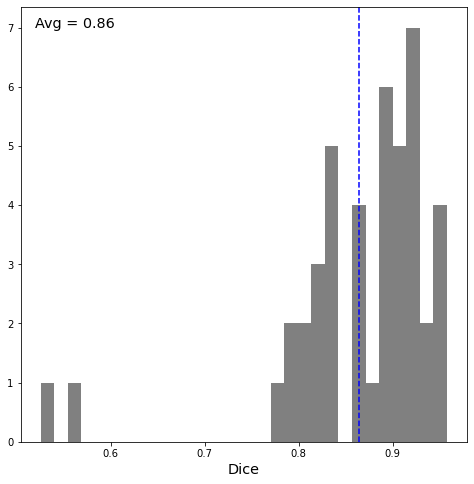

In [330]:
mean_dice = np.mean(results.dice)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.hist(results.dice, bins=30, color='grey')
ax.axvline(mean_dice, c='blue', linestyle='--')
ax.text(0.52, 7, f'Avg = {mean_dice:.2}', fontsize='x-large')
ax.set_xlabel('Dice', fontsize='x-large')
plt.show()

In [306]:
results['area_ventricles_diff'] = results['area_ventricles'] - results['pred_area_ventricles']
results['area_ventricles_avg'] = (results['area_ventricles'] + results['pred_area_ventricles']) / 2.0
avg = np.mean(results['area_ventricles_diff'])
std = np.std(results['area_ventricles_diff'])
corr = np.corrcoef(results['area_ventricles'], results['pred_area_ventricles'])[0][1]

Text(0, 0.5, 'Area - Predicted Area')

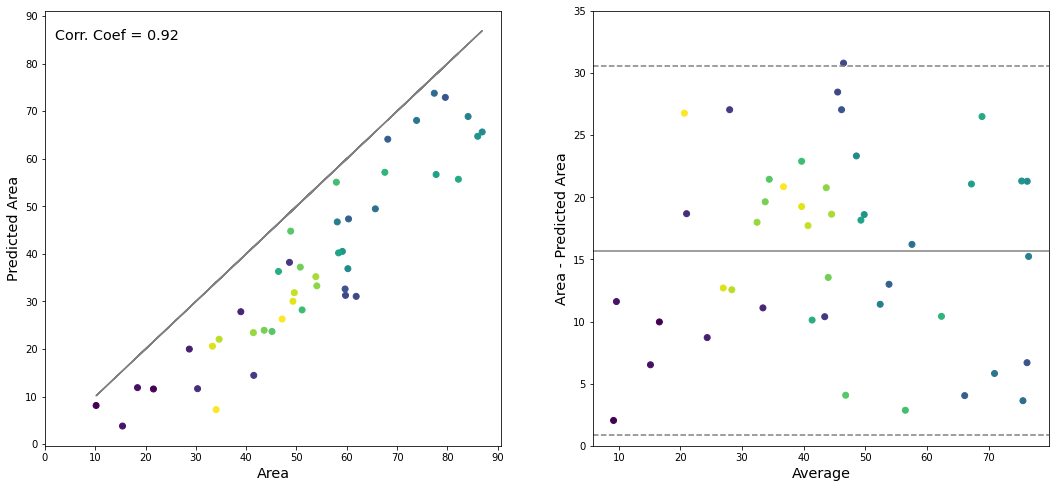

In [350]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Scatter plot of area vs predicted area
axes[0].plot(results['area_ventricles'], results['area_ventricles'], c='grey', linestyle='-')
axes[0].scatter(results['area_ventricles'], results['pred_area_ventricles'], c=results.slice_coord_norm)
axes[0].set_xticks(range(0, 100, 10))
axes[0].set_yticks(range(0, 100, 10))
axes[0].text(2, 85, f'Corr. Coef = {corr:.2}', fontsize='x-large')
axes[0].set_xlabel('Area', fontsize='x-large')
axes[0].set_ylabel('Predicted Area', fontsize='x-large')

# Bland-Altman plot
axes[1].scatter(results['area_ventricles_avg'], results['area_ventricles_diff'], c=results.slice_coord_norm)
axes[1].axhline(avg, c='grey')
axes[1].axhline(avg-1.96*std, c='grey', linestyle='--')
axes[1].axhline(avg+1.96*std, c='grey', linestyle='--')
axes[1].set_yticks(range(0, 40, 5))
axes[1].set_xlabel('Average', fontsize='x-large')
axes[1].set_ylabel('Area - Predicted Area', fontsize='x-large')

In [265]:
studies = list(study_dicts.keys())

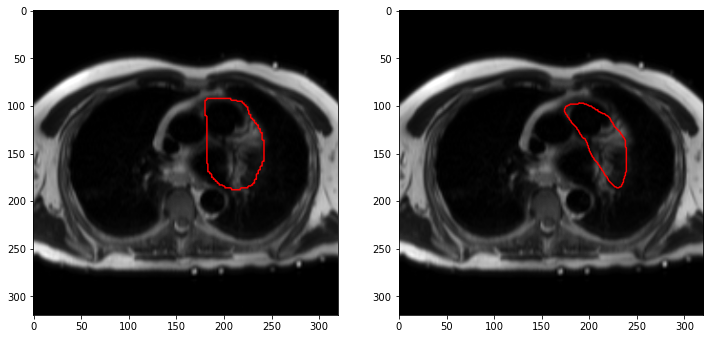

In [349]:
study = studies[0]
slice_idx = 22
fig, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(study_dicts[study][slice_idx]['image'], cmap='gray')
axes[0].plot(study_dicts[study][slice_idx]['contour_ventricles'][:, 0], study_dicts[study][slice_idx]['contour_ventricles'][:, 1], c='r')
axes[1].imshow(study_dicts[study][slice_idx]['image'], cmap='gray')
axes[1].plot(study_dicts[study][slice_idx]['pred_contour_ventricles'][:, 0], study_dicts[study][slice_idx]['pred_contour_ventricles'][:, 1], c='r')

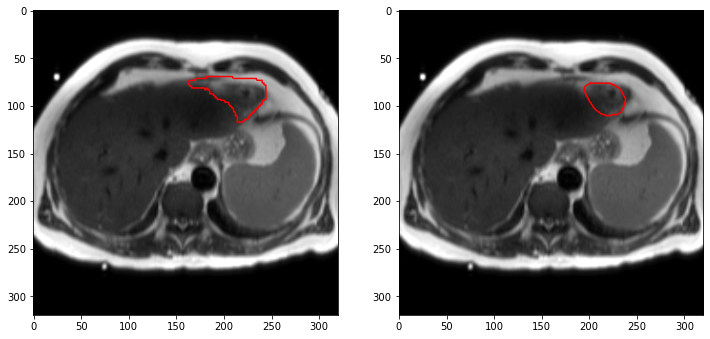

In [351]:
study = studies[0]
slice_idx = 0
fig, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(study_dicts[study][slice_idx]['image'], cmap='gray')
axes[0].plot(study_dicts[study][slice_idx]['contour_ventricles'][:, 0], study_dicts[study][slice_idx]['contour_ventricles'][:, 1], c='r')
axes[1].imshow(study_dicts[study][slice_idx]['image'], cmap='gray')
axes[1].plot(study_dicts[study][slice_idx]['pred_contour_ventricles'][:, 0], study_dicts[study][slice_idx]['pred_contour_ventricles'][:, 1], c='r')